In [1]:
import ipynb.fs.defs.MLIO_functions_source
#from ipynb.fs.full.MLIO_functions_source import 
import pandas as pd
import numpy as np
import gurobipy as gp
import dill
from gurobipy import GRB
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split

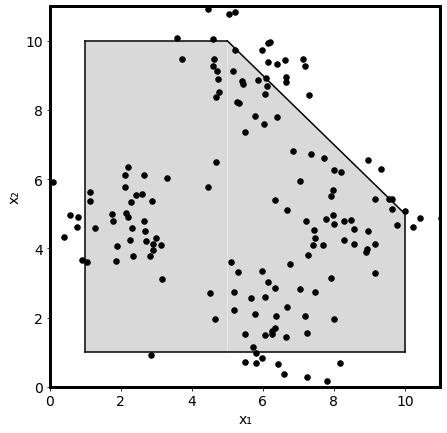

In [18]:
def twoD_example_random_generator (A,b,centers,num_points,figure):
    n_train = np.sum(num_points)
    X_train = np.zeros ([2,n_train])
    n_test = 0
    for i in range(centers.shape[0]):
        n_test += int(num_points[i]/4)
    X_test = np.zeros ([2,n_test])
    count_train = 0
    count_test = 0
    std_dev = 1
    for i in range(centers.shape[0]):
        X_train[0][count_train:count_train + num_points[i]] = std_dev* np.random.randn(1,num_points[i])+ centers.T[0,i]
        X_train[1][count_train:count_train + num_points[i]] = std_dev* np.random.randn(1,num_points[i])+ centers.T[1,i]
        X_test[0][count_test:count_test + int(num_points[i]/4)] = std_dev* np.random.randn(1,int(num_points[i]/4))+ centers.T[0,i]
        X_test[1][count_test:count_test + int(num_points[i]/4)] = std_dev* np.random.randn(1,int(num_points[i]/4))+ centers.T[1,i]
        count_train = count_train + num_points[i]
        count_test = count_test + int(num_points[i]/4)
    if figure == True:
        plt.figure(figsize=(7,7))
        s = 35
        plt.scatter(X_train[0, :], X_train[1, :], c="black", s=30, edgecolor="black", label="train_data")
        #plt.scatter(X_test[0, :], X_test[1, :], c="red", s=30, edgecolor="red", label="Test_data")
        plt.xlim([0, 11])
        plt.ylim([0, 11])
        plt.xlabel(u'x\u2081')
        plt.ylabel(u'x\u2082')
        plt.plot([1,1], [1, 10], c="black")
        plt.plot([10,10], [1, 5], c="black")
        plt.plot([1,5], [10, 10], c="black")
        plt.plot([1,10], [1, 1], c="black")
        plt.plot([10,5], [5, 10], c="black")
        plt.fill_between([1,5], [10,10],[1,1], facecolor='black', alpha=0.15)
        plt.fill_between([5,10], [10,5],[1,1], facecolor='black', alpha=0.15)
    return X_train, X_test


A = np.array (([1,0]
              ,[-1,0]
              ,[0,1]
              ,[0,-1]
              ,[1,1]))
b = np.array ([10,-1,10,-1,15])
centers = np.array([[2,5]
                   ,[6,2]
                   ,[8.5,5]
                   ,[5.5,9]])
num_points = np.array([40,40,40,40])
figure = True
X_train, X_test= twoD_example_random_generator (A,b,centers,num_points,True)
X_train = X_train.T
X_test = X_test.T
#X_train

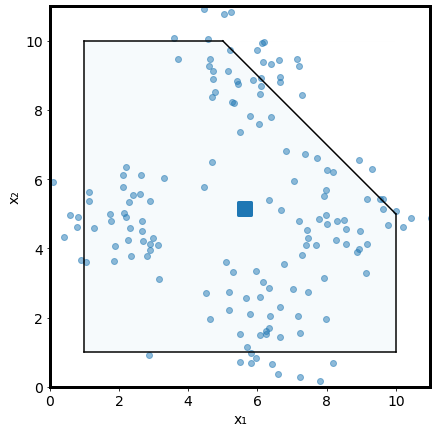

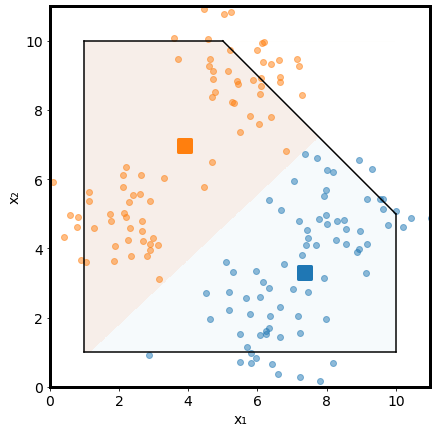

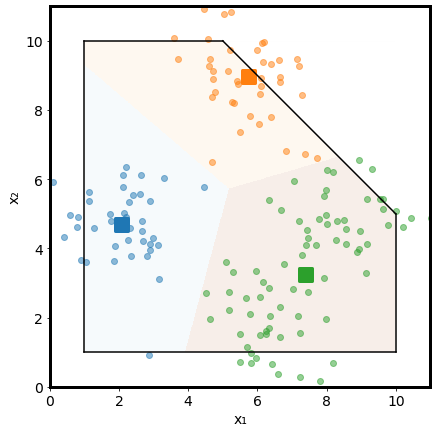

In [19]:
from ipynb.fs.full.MLIO_functions_source import find_cluster_from_centroid
from ipynb.fs.full.MLIO_functions_source import plot_coloured_clusters
from ipynb.fs.full.MLIO_functions_source import k_means_for_comparison
k_means_for_comparison(A,b,X_train.T,3, False)

In [38]:
def MIQCP_for_2D_example(A,b,X, max_number_of_clusters,figure):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T       
    #max_number_of_clusters = 8
    dif =                   np.zeros (max_number_of_clusters)
    dif_train_MIQCP =             np.zeros (max_number_of_clusters)
    dif_train_MIQCP_2 = np.zeros (max_number_of_clusters)
    dif_test =              np.zeros (max_number_of_clusters)
    opt_gap =               np.zeros (max_number_of_clusters)
    dif_train_cluster_avg = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_1 = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_2 = np.zeros (max_number_of_clusters)
    IO_points_dic = {}
    count = 0  
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        #kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        #print (np.unique(kmeans.labels_))
        #X_train[m]= kmeans.labels_
        #IO_points = kmeans.cluster_centers_
        IO_points ,C = MLIO_MIQCP(A,b,XT,n + 1)
        #IO_points = IO_points.reshape(n+1,2)
        centroids = np.zeros ([n+1,2])
        for i in range(n+1):
            centroids [i,0] = IO_points[i]
            centroids [i,1] = IO_points[n+1+i]
        if (X.shape[0] ==2) or (X.shape[1] ==2):
            plot_coloured_clusters(X,centroids,count)
        count += 1 
        X_centroids = find_cluster_from_centroid(X, centroids)
        for j in np.unique(X_centroids[2,:]):
            indices =[i for i in range(X_centroids.shape[1]) if X_centroids[2,i] == j]              
            print(centroids[int(j),:])
            dif_train_MIQCP[n] += sum (sum (abs (X.T[indices,:] - centroids[int(j),:])))
            dif_train_MIQCP_2[n] += sum(np.linalg.norm(X.T[indices,:] - centroids[int(j),:], axis=1, ord = 1))
    return dif_train_MIQCP,dif_train_MIQCP_2

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 813 rows, 811 columns and 1464 nonzeros
Model fingerprint: 0xf9aeb614
Model has 321 quadratic constraints
Variable types: 651 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 807 rows and 511 columns
Presolve time: 0.00s
Presolved: 15 rows, 302 columns, 339 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 302 continuous, 0 integer (0 binary)

Root relaxation: objective 6.730032e+02, 9 iterations, 0.00 seconds



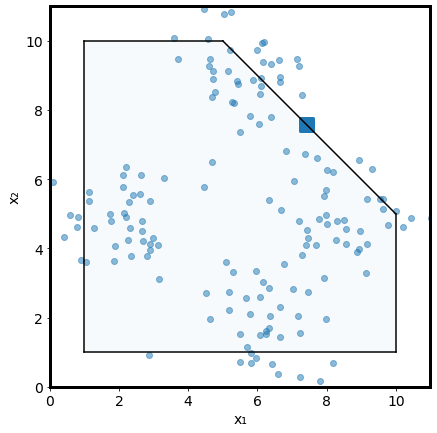

[7.4149969 7.5850031]
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 826 rows, 980 columns and 1648 nonzeros
Model fingerprint: 0xd4afe278
Model has 642 quadratic constraints
Variable types: 660 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 498 rows and 162 columns
Presolve time: 0.01s
Presolved: 3546 rows, 2422 columns, 9372 nonzeros
Presolved model has 640 SOS constraint(s)
Presolved model has 4 bilinear constraint(s)
Variable types: 1942 continuous, 480 integer (480 binar

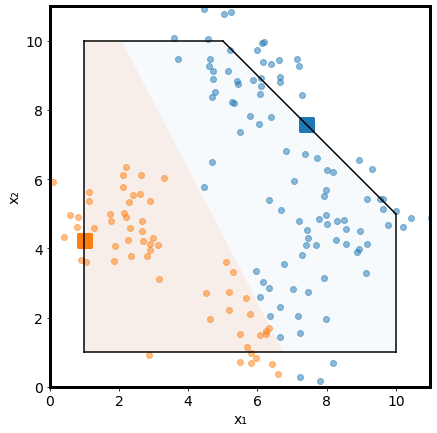

[7.4149969 7.5850031]
[1.         4.25205058]
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 839 rows, 1149 columns and 1832 nonzeros
Model fingerprint: 0x107fe13f
Model has 963 quadratic constraints
Variable types: 669 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 347 rows and 2 columns
Presolve time: 0.01s
Presolved: 6279 rows, 4993 columns, 15658 nonzeros
Presolved model has 1920 SOS constraint(s)
Presolved model has 6 bilinear constraint(s)
Variable types: 3553 continuou

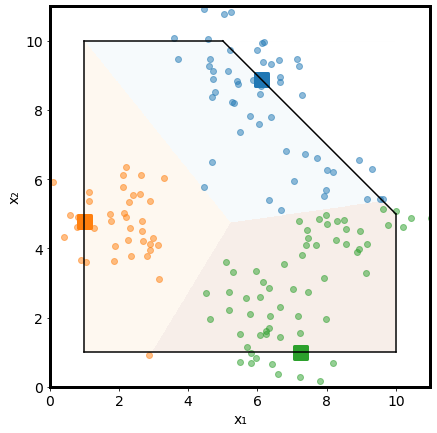

[6.11241592 8.88758408]
[1.         4.78177605]
[7.22934029 1.        ]


array([899.64582638, 647.68846924, 432.04854266])

In [26]:
from ipynb.fs.full.MLIO_functions_source import MLIO_MIQCP
#from ipynb.fs.full.MLIO_functions_source import MIQCP_for_2D_example
dif_train_MIQCP,dif_train_MIQCP_2 = MIQCP_for_2D_example(A,b,X_train.T,3, False)
dif_train_MIQCP

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 813 rows, 811 columns and 1464 nonzeros
Model fingerprint: 0xf9aeb614
Model has 321 quadratic constraints
Variable types: 651 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 807 rows and 511 columns
Presolve time: 0.01s
Presolved: 15 rows, 302 columns, 339 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 302 continuous, 0 integer (0 binary)

Root relaxation: objective 6.730032e+02, 9 iterations, 0.00 seconds



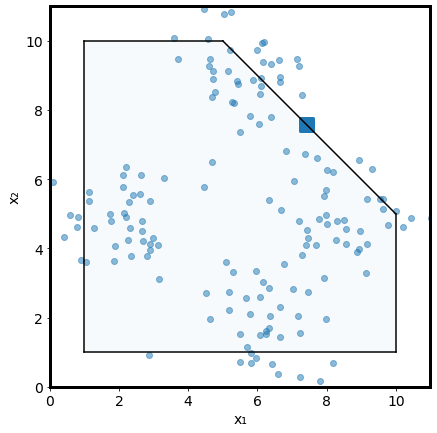

[7.4149969 7.5850031]
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 826 rows, 980 columns and 1648 nonzeros
Model fingerprint: 0xd4afe278
Model has 642 quadratic constraints
Variable types: 660 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 498 rows and 162 columns
Presolve time: 0.03s
Presolved: 3546 rows, 2422 columns, 9372 nonzeros
Presolved model has 640 SOS constraint(s)
Presolved model has 4 bilinear constraint(s)
Variable types: 1942 continuous, 480 integer (480 binar

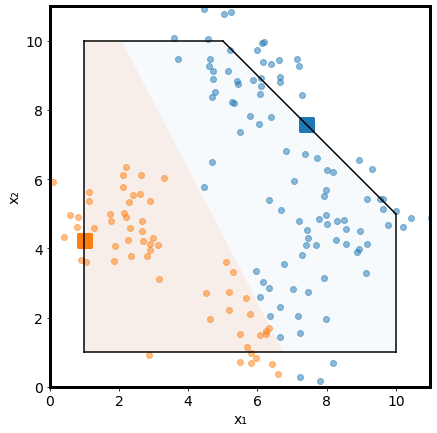

[7.4149969 7.5850031]
[1.         4.25205058]
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 839 rows, 1149 columns and 1832 nonzeros
Model fingerprint: 0x107fe13f
Model has 963 quadratic constraints
Variable types: 669 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [9e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 347 rows and 2 columns
Presolve time: 0.02s
Presolved: 6279 rows, 4993 columns, 15658 nonzeros
Presolved model has 1920 SOS constraint(s)
Presolved model has 6 bilinear constraint(s)
Variable types: 3553 continuou

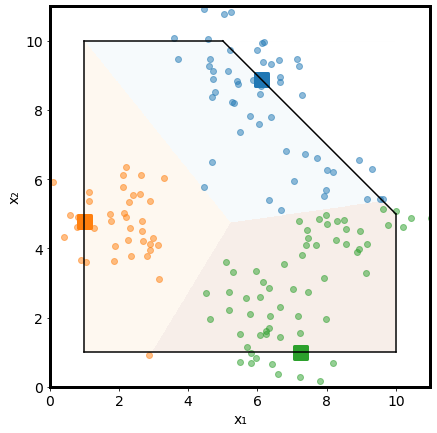

[6.11241592 8.88758408]
[1.         4.78177605]
[7.22934029 1.        ]


array([899.64582638, 647.68846924, 432.04854266])

In [39]:
dif_train_MIQCP,dif_train_MIQCP_2 = MIQCP_for_2D_example(A,b,X_train.T,3, False)
dif_train_MIQCP_2

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


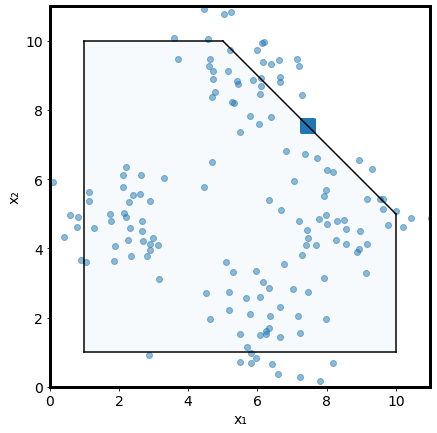

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


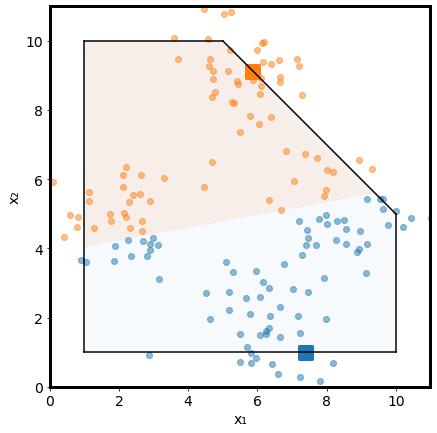

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


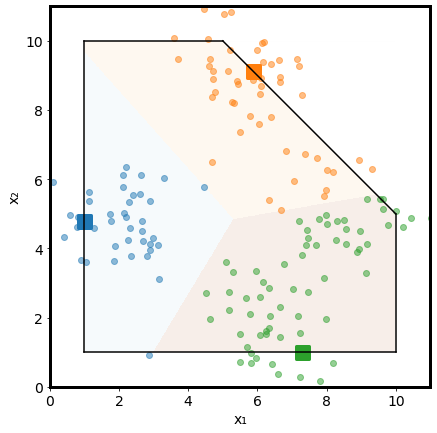

In [21]:
import warnings
warnings.filterwarnings('ignore')
from ipynb.fs.full.MLIO_functions_source import IO
from ipynb.fs.full.MLIO_functions_source import find_cluster
from ipynb.fs.full.MLIO_functions_source import SEQ_MLIO_2D
X_train_SEQ_MLIO, dif_train_SEQ_MLIO, opt_gap_SEQ_MLIO, dif_train_cluster_avg_1_SEQ_MLIO,dif_train_cluster_avg_2_SEQ_MLIO, dif_test_SEQ_MLIO,IO_points_SEQ_MLIO, Cluster_avg_SEQ_MLIO,x_mean_SEQ_MLIO = SEQ_MLIO_2D(A,b,X_train.T,X_test.T, 3,False)

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


<Figure size 432x288 with 0 Axes>

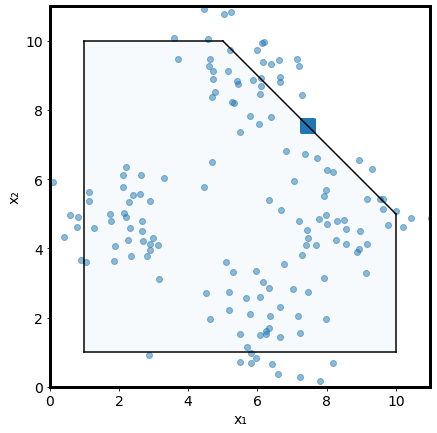

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  

<Figure size 432x288 with 0 Axes>

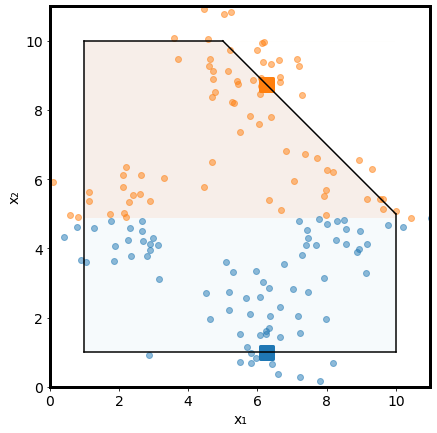

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  

<Figure size 432x288 with 0 Axes>

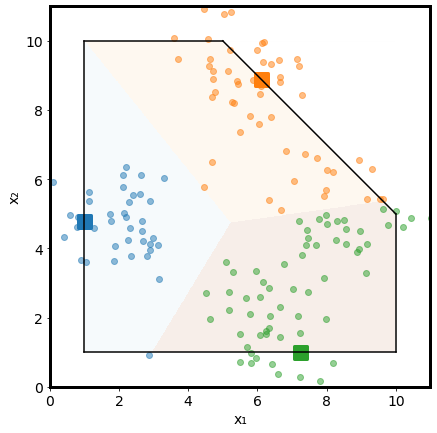

In [22]:
from ipynb.fs.full.MLIO_functions_source import Embedded_partition_learn
dif_EMB_MLIO,dif_train_EMB_MLIO, centers_new_EMB_MLIO, opt_gap_emb_EMB_MLIO,data_emb_EMB_MLIO,dif_test_emb_EMB_MLIO, clusters_EMB_MLIO = Embedded_partition_learn(A,b,X_train.T,X_test.T, 3, False)

In [41]:
from ipynb.fs.full.MLIO_functions_source import Embedded_partition_learn_2
dif_train_EMB_MLIO_2, centers_new_EMB_MLIO_2, opt_gap_emb_EMB_MLIO_2,data_emb_EMB_MLIO_2,dif_test_emb_EMB_MLIO_2, clusters_EMB_MLIO_2 = Embedded_partition_learn_2(A,b,X_train.T,X_test.T, 3, False)

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
print('SEQ_MLIO sum of distances is ')
print(dif_train_SEQ_MLIO)
print('EMB_MLIO sum of distances is ')
print(dif_train_EMB_MLIO)

SEQ_MLIO sum of distances is 
[899.64582638 686.69009903 440.12468189]
EMB_MLIO sum of distances is 
[899.64582638 652.33947496 430.03623074]


In [23]:
dif_train_SEQ_MLIO

array([899.64582638, 686.69009903, 440.12468189])

In [24]:
dif_train_EMB_MLIO

array([899.64582638, 652.33947496, 430.03623074])

In [31]:
dif_train_MIQCP

array([899.64582638, 647.68846924, 432.04854266])

In [40]:
dif_train_MIQCP_2

array([899.64582638, 647.68846924, 432.04854266])

In [29]:
MIQCP_obj = [899.64,639.73,430.03]
MIQCP_obj

[899.64, 639.73, 430.03]

In [14]:
dif_train_EMB_MLIO_2

array([553.25355583, 402.30270084, 259.05569688])

In [15]:
dif_EMB_MLIO

array([407.51345325, 329.97636412, 196.96475653])

NameError: name 'dif_train_100times' is not defined

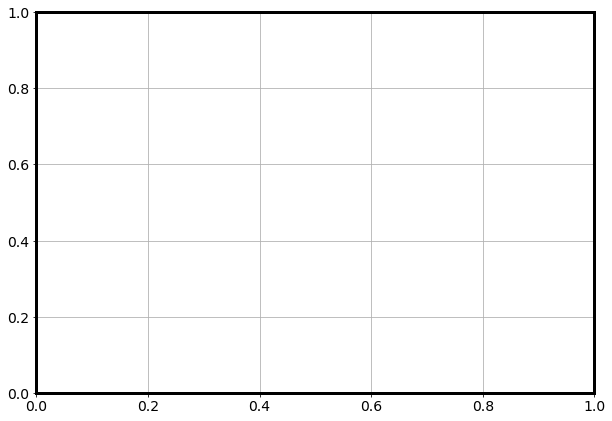

In [4]:
plt.figure(figsize=(10, 7))
s = 100
plt.grid()
plt.rcParams.update({'font.size': 16})
plt.scatter(range(1, dif_train_100times.shape[0]+ 1), dif_train_100times.mean(axis = 0)/(160*44), c="navy", s=s, edgecolor="black", label="Disjoint ML and IO")
plt.plot   (range(1, dif_train_100times.shape[0]+ 1), dif_train_100times.mean(axis = 0)/(160*44), c="navy")
plt.fill_between(range(1, dif_train_100times.shape[0]+ 1), (dif_train_100times.mean(axis = 0)-2*dif_train_100times.std(axis = 0)/14)/(160*44), 
                 (dif_train_100times.mean(axis = 0)+2*dif_train_100times.std(axis = 0)/14)/(160*44), alpha =0.20)


plt.scatter(np.arange(1, dif_train_base_100times.shape[0]+ 1), dif_train_base_100times.mean(axis = 0)/(160*44), s=s, edgecolor="black",c="red", label="Embedded MLIO")
plt.plot   (range(1, dif_train_base_100times.shape[0]+ 1), dif_train_base_100times.mean(axis = 0)/(160*44), c="red")
plt.fill_between(range(1, dif_train_base_100times.shape[0]+ 1), (dif_train_base_100times.mean(axis = 0)-2*dif_train_base_100times.std(axis = 0)/14)/(160*44), 
                 (dif_train_base_100times.mean(axis = 0)+2*dif_train_base_100times.std(axis = 0)/14)/(160*44), alpha =0.20)

plt.xlabel('Number of Clusters')
plt.xlim([0, 21])
plt.xticks(np.arange(2, 21, 2.0))
plt.ylabel('Average Distance')
plt.title('In sample sum of Loss')
#plt.legend(loc=0,bbox_to_anchor=(0.67, 0., 0., -0.2))
plt.legend()

plt.savefig('Saved_figures/Diet_in_sum_loss.png')
#plt.savefig('Saved_figures/2D_in-sample_sum_loss.png')